In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/project/crop_part1

/content/gdrive/MyDrive/project/crop_part1


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]
import random

In [ ]:
input_img_paths = os.listdir()
print(len(input_img_paths))

9780


(200, 200, 3)


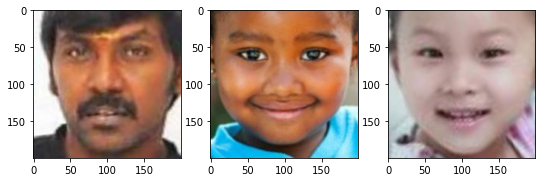

In [ ]:
idx1 = random.randint(0, len(input_img_paths))
idx2 = random.randint(0, len(input_img_paths))
idx3 = random.randint(0, len(input_img_paths))
img1 = cv2.cvtColor(cv2.imread(input_img_paths[idx1]), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(input_img_paths[idx2]), cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(cv2.imread(input_img_paths[idx3]), cv2.COLOR_BGR2RGB)
plt.subplot(131), plt.imshow(img1)
plt.subplot(132), plt.imshow(img2)
plt.subplot(133), plt.imshow(img3)
print(img1.shape)

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


def preprocess(df):
    return [array.astype("float32") / 255.0 for array in df]

def resize(df):
    return [cv2.resize(array, (100,100), interpolation= cv2.INTER_LINEAR) for array in df]
  
def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 5

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
from tqdm import tqdm

train_data = []
for k in range(1000,len(input_img_paths)):
  ph = cv2.cvtColor(cv2.imread(input_img_paths[k]), cv2.COLOR_BGR2RGB)
  train_data.append(ph)
  if k == 6000:
    break

In [ ]:
len(train_data)

5001

In [ ]:
# Normalize the data
#train_data = preprocess(train_data)

# Create a copy of the data with added noise
resize_train_data = resize(train_data)

In [ ]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, Convolution2DTranspose
from keras.layers import Concatenate, Add, Average, Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU

n1=64
n2=128
n3=256

init = Input(shape=(100, 100, 3))

c1 = Convolution2D(n1, (3, 3), activation='relu', padding='same')(init)
c1 = Convolution2D(n1, (3, 3), activation='relu', padding='same')(c1)

x = MaxPooling2D((2, 2))(c1)

c2 = Convolution2D(n2, (3, 3), activation='relu', padding='same')(x)
c2 = Convolution2D(n2, (3, 3), activation='relu', padding='same')(c2)

x = MaxPooling2D((2, 2))(c2)

c3 = Convolution2D(n3, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D()(c3)

c2_2 = Convolution2D(n2, (3, 3), activation='relu', padding='same')(x)
c2_2 = Convolution2D(n2, (3, 3), activation='relu', padding='same')(c2_2)

m1 = Add()([c2, c2_2])
m1 = UpSampling2D()(m1)

c1_2 = Convolution2D(n1, (3, 3), activation='relu', padding='same')(m1)
c1_2 = Convolution2D(n1, (3, 3), activation='relu', padding='same')(c1_2)

m2 = Add()([c1, c1_2])

bb = UpSampling2D()(m2)
decoded = Convolution2D(3, (5, 5), activation='linear', padding='same')(bb)



auto_encoder = tf.keras.models.Model(inputs=init, outputs=decoded)
auto_encoder.compile(optimizer='adadelta', loss='mean_squared_error')
auto_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 100, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

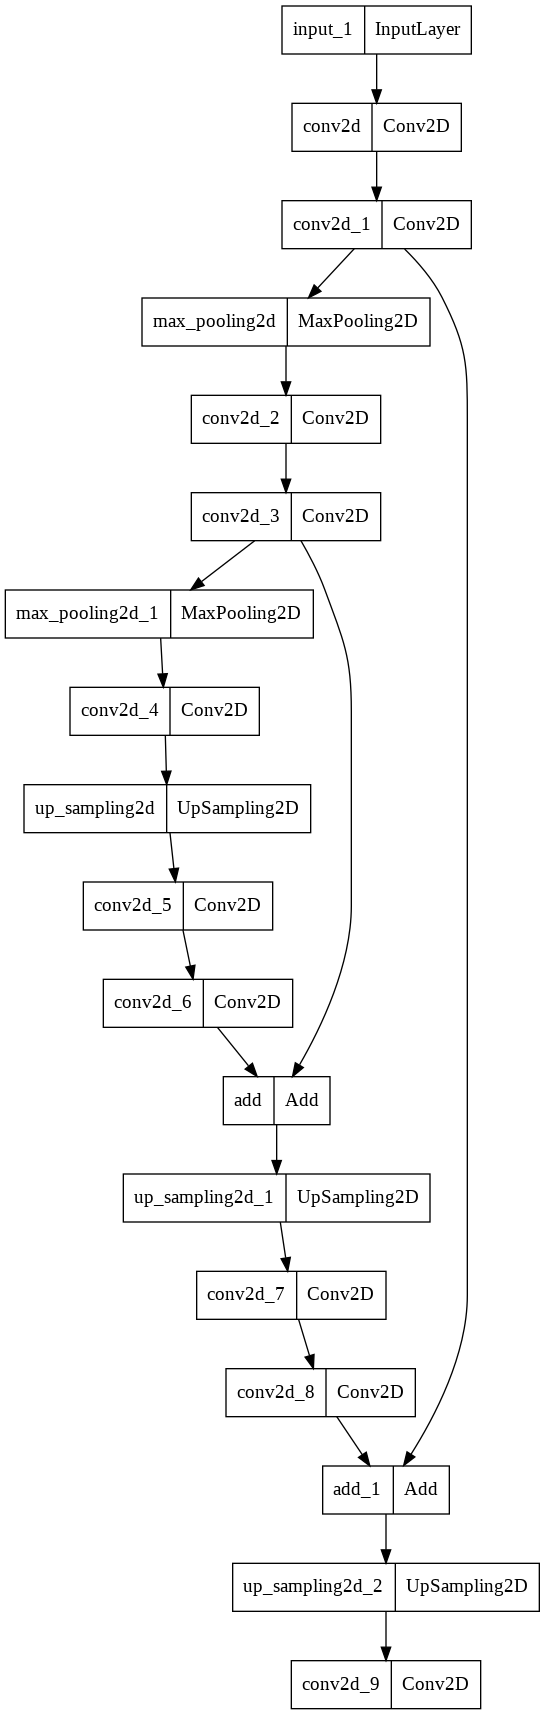

In [ ]:
tf.keras.utils.plot_model(auto_encoder)

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
auto_encoder.fit(
    x=np.array(resize_train_data),
    y=np.array(train_data),
    epochs=100,
    batch_size=50,
    shuffle=True,
    validation_data=(np.array(resize_train_data), np.array(train_data)),
)

Epoch 1/100
101/101 [==============================] - 59s 435ms/step - loss: 14981.5811 - val_loss: 1819.4481
Epoch 2/100
101/101 [==============================] - 43s 429ms/step - loss: 1368.4980 - val_loss: 1056.8923
Epoch 3/100
101/101 [==============================] - 44s 437ms/step - loss: 713.0039 - val_loss: 439.1996
Epoch 4/100
101/101 [==============================] - 45s 444ms/step - loss: 335.6068 - val_loss: 228.9658
Epoch 5/100
101/101 [==============================] - 45s 448ms/step - loss: 208.7369 - val_loss: 173.7766
Epoch 6/100
101/101 [==============================] - 45s 450ms/step - loss: 162.3151 - val_loss: 143.4128
Epoch 7/100
101/101 [==============================] - 46s 453ms/step - loss: 135.3193 - val_loss: 202.7554
Epoch 8/100
101/101 [==============================] - 46s 455ms/step - loss: 116.9863 - val_loss: 113.2308
Epoch 9/100
101/101 [==============================] - 46s 457ms/step - loss: 107.4382 - val_loss: 100.4368
Epoch 10/100
101/101 [=

In [ ]:
auto_encoder.save_weights('ModelWeights1')
auto_encoder.save('Model1.h5')

In [ ]:
predictions = auto_encoder.predict(np.array(resize_train_data))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


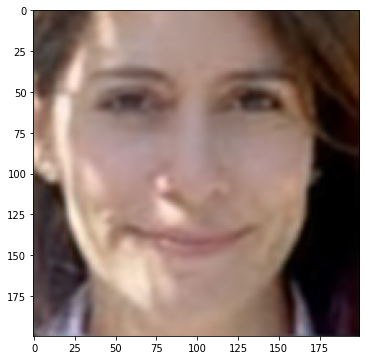

In [ ]:
plt.imshow(predictions[2].astype(int))

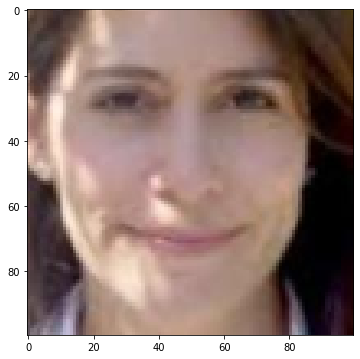

In [ ]:
plt.imshow(resize_train_data[2])

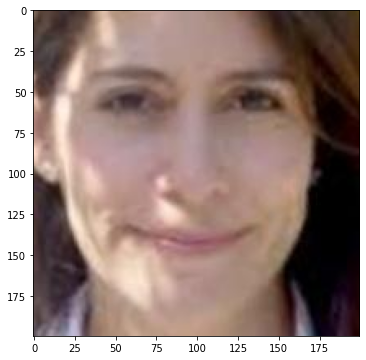

In [ ]:
plt.imshow(train_data[2])

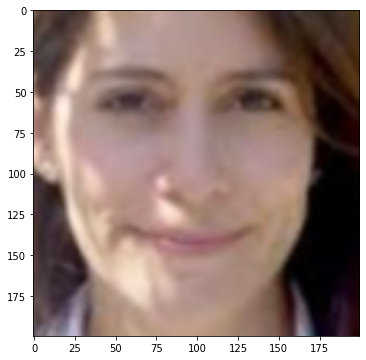

In [ ]:
plt.imshow(cv2.resize(resize_train_data[2], (200,200), interpolation= cv2.INTER_LINEAR))